<a href="https://colab.research.google.com/github/ShadyGirgis79/Bank-Loan/blob/main/Bank_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Postprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time

# Dataset: **"Bank Loan"**

In [ ]:
bank = pd.read_csv("loan_train.csv")
print(bank.shape)
bank.head()

(346, 10)


,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    346 non-null    int64 
 1   Unnamed: 0      346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


In [ ]:
bank.describe()

,Unnamed: 0.1,Unnamed: 0,Principal,terms,age
count,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306
std,115.459715,115.459715,109.425530,7.991006,6.039418
min,0.000000,0.000000,300.000000,7.000000,18.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000


In [ ]:
bank.isnull().sum()

Unnamed: 0.1      0
Unnamed: 0        0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

# Preprocessing

## Changing Categorical Values to Numerical Values

In [ ]:
# There are 3 categorical columns: 'Gender', 'education', and 'loan_status'
bank['Gender'] = bank['Gender'].map({'male':1 ,'female':0})
bank['education'] = bank['education'].map({'High School or Below':0 ,'college':1, 'Bechalor':2, 'Master or Above':3})
bank['loan_status'] = bank['loan_status'].map({'PAIDOFF':0 ,'COLLECTION':1})
bank.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,1000,30,9/8/2016,10/7/2016,45,0,1
1,2,2,0,1000,30,9/8/2016,10/7/2016,33,2,0
2,3,3,0,1000,15,9/8/2016,9/22/2016,27,1,1
3,4,4,0,1000,30,9/9/2016,10/8/2016,28,1,0
4,6,6,0,1000,30,9/9/2016,10/8/2016,29,1,1


## Managing Date Format

In [ ]:
from datetime import datetime

eff_dates = []
for days in bank['effective_date']:
  dates = datetime.strptime(days, "%m/%d/%Y")
  ordinal_day = dates.timetuple().tm_yday
  eff_dates.append(ordinal_day)

bank['effective_date'] = eff_dates
bank.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,1000,30,252,10/7/2016,45,0,1
1,2,2,0,1000,30,252,10/7/2016,33,2,0
2,3,3,0,1000,15,252,9/22/2016,27,1,1
3,4,4,0,1000,30,253,10/8/2016,28,1,0
4,6,6,0,1000,30,253,10/8/2016,29,1,1


In [ ]:
due_dates = []
for days in bank['due_date']:
  dates = datetime.strptime(days, "%m/%d/%Y")
  ordinal_day = dates.timetuple().tm_yday
  due_dates.append(ordinal_day)

bank['due_date'] = due_dates
bank.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,1000,30,252,281,45,0,1
1,2,2,0,1000,30,252,281,33,2,0
2,3,3,0,1000,15,252,266,27,1,1
3,4,4,0,1000,30,253,282,28,1,0
4,6,6,0,1000,30,253,282,29,1,1


## Data Normalization

In [ ]:
big_values_columns = ['Principal', 'terms' , 'effective_date' , 'due_date' , 'age']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns using Min-Max normalization
bank[big_values_columns] = scaler.fit_transform(bank[big_values_columns])

bank.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,0,1.0,1.000000,0.000000,0.368421,0.818182,0,1
1,2,2,0,1.0,1.000000,0.000000,0.368421,0.454545,2,0
2,3,3,0,1.0,0.347826,0.000000,0.105263,0.272727,1,1
3,4,4,0,1.0,1.000000,0.166667,0.385965,0.303030,1,0
4,6,6,0,1.0,1.000000,0.166667,0.385965,0.333333,1,1


## Removing Unneeded Columns

In [ ]:
bank = bank.drop(['Unnamed: 0.1','Unnamed: 0'] , axis = 1)
bank.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,1.0,1.000000,0.000000,0.368421,0.818182,0,1
1,0,1.0,1.000000,0.000000,0.368421,0.454545,2,0
2,0,1.0,0.347826,0.000000,0.105263,0.272727,1,1
3,0,1.0,1.000000,0.166667,0.385965,0.303030,1,0
4,0,1.0,1.000000,0.166667,0.385965,0.333333,1,1


## Removing Outliers using the Z-Score Method

In [ ]:
#Calculate the mean and standard deviation for each column
bank_means = np.mean(bank, axis=0)
phone_std_devs = np.std(bank, axis=0)

#Calculate the z-score for each cell based on its column
z_scores_bank = (bank - bank_means) / phone_std_devs

#Define a threshold for outliers (e.g., ±3 standard deviations)
threshold = 3

#Identify outliers
outliers_BCD = np.abs(z_scores_bank) > threshold

print(z_scores_bank.shape)
z_scores_bank.head()

(346, 8)


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,-0.575125,0.515785,0.920718,-3.018614,0.203466,2.331526,-0.995125,0.420560
1,-0.575125,0.515785,0.920718,-3.018614,0.203466,0.341701,1.838728,-2.377782
2,-0.575125,0.515785,-0.959111,-3.018614,-1.206397,-0.653211,0.421802,0.420560
3,-0.575125,0.515785,0.920718,-2.149695,0.297457,-0.487392,0.421802,-2.377782
4,-0.575125,0.515785,0.920718,-2.149695,0.297457,-0.321573,0.421802,0.420560


In [ ]:
#Remove outliers
bank_cleaned = bank[~np.any(outliers_BCD, axis=1)]

print(bank_cleaned.shape)
bank_cleaned.head()

(321, 8)


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
3,0,1.000000,1.000000,0.166667,0.385965,0.303030,1,0
4,0,1.000000,1.000000,0.166667,0.385965,0.333333,1,1
5,0,1.000000,1.000000,0.166667,0.385965,0.545455,1,1
6,0,1.000000,1.000000,0.166667,0.385965,0.303030,1,1
7,0,0.714286,0.347826,0.333333,0.140351,0.242424,1,1


## Correlation Matrix

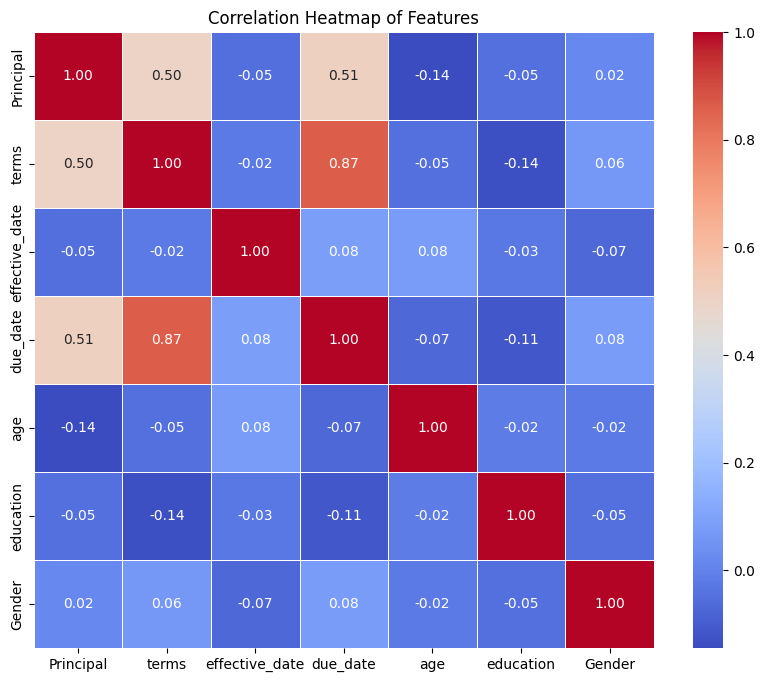

In [ ]:
#Exclude output column
feature_columns = bank_cleaned.iloc[:, 1:]

#Calculate the correlation matrix
corr_matrix = feature_columns.corr()

#Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
bank = pd.DataFrame(bank_cleaned)
print(bank.shape)
bank.head()

(321, 8)


,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
3,0,1.000000,1.000000,0.166667,0.385965,0.303030,1,0
4,0,1.000000,1.000000,0.166667,0.385965,0.333333,1,1
5,0,1.000000,1.000000,0.166667,0.385965,0.545455,1,1
6,0,1.000000,1.000000,0.166667,0.385965,0.303030,1,1
7,0,0.714286,0.347826,0.333333,0.140351,0.242424,1,1


## Splitting the Data

In [ ]:
X = bank.drop(['loan_status'] , axis = 1)
y = bank['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

## Dictionaries for Comparison

In [ ]:
# Create a dictionary of accuracies for later comparison between models
accuracies = {}

# Create a dictionary of times for later comparison between models
times = {}

# Models

## KNN

In [ ]:
# Training the model 15 times; each with different k, ranging from 1 to 15
k_values = range(1, 16)
errors = []
for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  knn_pred = knn.predict(X_test)
  error = 1 - accuracy_score(y_test, knn_pred)
  errors.append(error)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': knn_pred}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,0


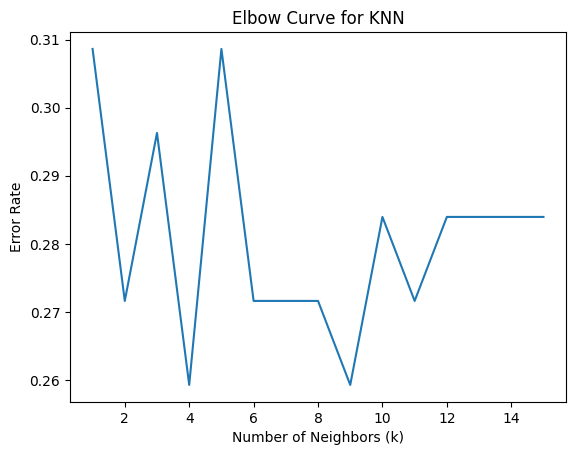

In [ ]:
# Plot the elbow curve
plt.plot(k_values, errors)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Curve for KNN')
plt.show()

In [ ]:
# The best k is 9, as it has the lowest error rate, which is wider than where k = 4, so is more stable
knn = KNeighborsClassifier(n_neighbors=15)
start_time = time.time()
knn.fit(X_train, y_train)
tt_knn = time.time() - start_time
times['knn'] = tt_knn
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
accuracies['knn'] = knn_acc
print("Accuracy:", knn_acc)

Accuracy: 0.7160493827160493


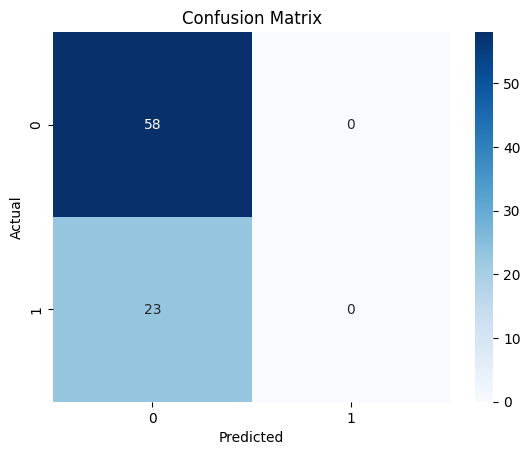

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, knn_pred)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Naïve Bayes Classifier

In [ ]:
# This model has only one parameter which is 'var_smoothing', and its best value is the default: '1e-9'
nb = GaussianNB()
start_time = time.time()
nb.fit(X_train, y_train)
tt_nb = time.time() - start_time
times['nb'] = tt_nb

In [ ]:
nb_pred = nb.predict(X_test)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': nb_pred}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,1


In [ ]:
nb_acc = accuracy_score(y_test, nb_pred)
accuracies['nb'] = nb_acc
print("Accuracy:", nb_acc)

Accuracy: 0.6419753086419753


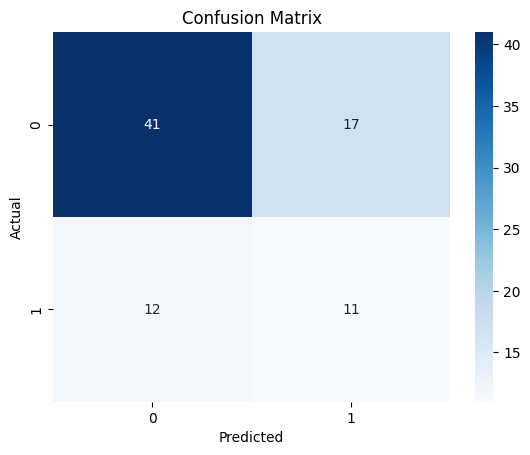

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, nb_pred)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## MLP Classifier

In [ ]:
# Training with default parameters: a 100-node hidden layer, relu activation, adam solver, and alpha=0.0001
mlp = MLPClassifier(random_state=42)
start_time = time.time()
mlp.fit(X_train, y_train)
tt_mlp_1 = time.time() - start_time
times['mlp_1'] = tt_mlp_1

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
mlp_pred = mlp.predict(X_test)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': mlp_pred}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,0


In [ ]:
mlp_acc = accuracy_score(y_test, mlp_pred)
accuracies['mlp_1'] = mlp_acc
print("Accuracy:", mlp_acc)

Accuracy: 0.7160493827160493


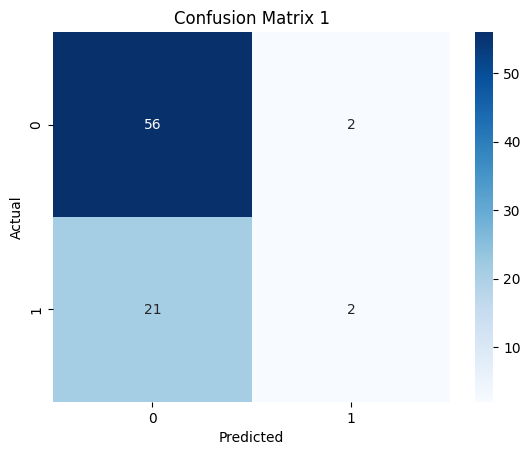

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, mlp_pred)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')

# Show the plot
plt.show()

### Changing the Hyperparameters

In [ ]:
# Changing parameters: 3 hidden layers with 160, 80, 40 nodes, tanh activation, and lbfgs solver
mlp_2 = MLPClassifier(hidden_layer_sizes=(160, 80, 40), activation='tanh', solver='lbfgs', random_state=42)
start_time = time.time()
mlp_2.fit(X_train, y_train)
tt_mlp_2 = time.time() - start_time
times['mlp_2'] = tt_mlp_2

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mlp_pred_2 = mlp_2.predict(X_test)

In [ ]:
mlp_acc_2 = accuracy_score(y_test, mlp_pred_2)
accuracies['mlp_2'] = mlp_acc_2
print("Accuracy:", mlp_acc_2)

Accuracy: 0.7654320987654321


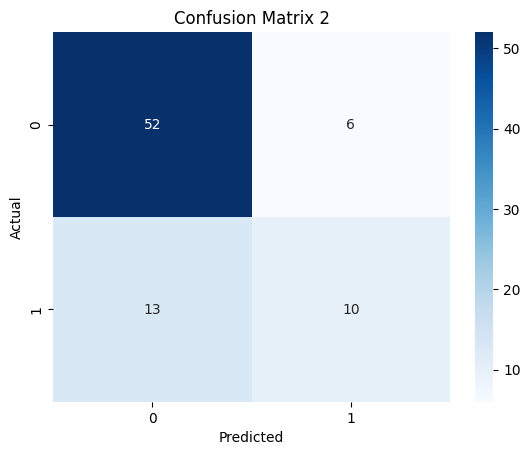

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, mlp_pred_2)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')

# Show the plot
plt.show()

### Changing the Hyperparameters Once More

In [ ]:
# Increasing the max number of iterations from 200 to 1000
mlp_3 = MLPClassifier(hidden_layer_sizes=(160, 80, 40), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
start_time = time.time()
mlp_3.fit(X_train, y_train)
tt_mlp_3 = time.time() - start_time
times['mlp_3'] = tt_mlp_3

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mlp_pred_3 = mlp_3.predict(X_test)

In [ ]:
mlp_acc_3 = accuracy_score(y_test, mlp_pred_3)
accuracies['mlp_3'] = mlp_acc_3
print("Accuracy:", mlp_acc_3)

Accuracy: 0.7777777777777778


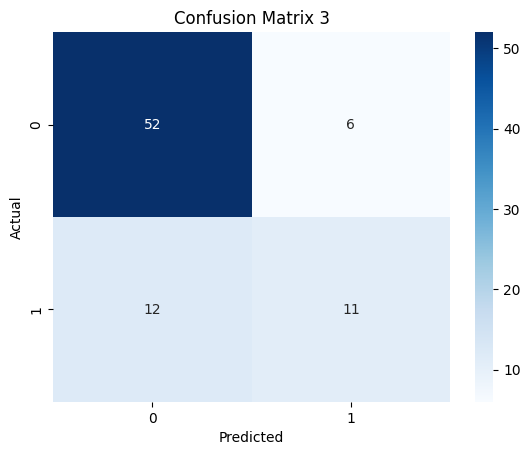

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, mlp_pred_3)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 3')

# Show the plot
plt.show()

**The model with the 3 hidden layers and 1000 iterations is the best of 3.**

## SVM classifier

In [ ]:
# Training with the default kernel 'rbf'
svm = SVC(random_state=42)
start_time = time.time()
svm.fit(X_train, y_train)
tt_svm_1 = time.time() - start_time
times['svm_1'] = tt_svm_1

In [ ]:
svm_pred = svm.predict(X_test)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': svm_pred}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,0


In [ ]:
svm_acc = accuracy_score(y_test, svm_pred)
accuracies['svm_1'] = svm_acc
print("Accuracy:", svm_acc)

Accuracy: 0.7160493827160493


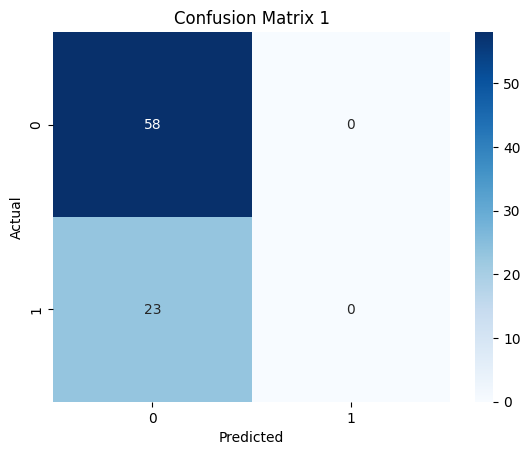

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, svm_pred)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')

# Show the plot
plt.show()

### Changing the Hyperparameters

In [ ]:
# Training with a polynomial 2nd degree kernel
svm_2 = SVC(kernel='poly', degree=2, random_state=42)
start_time = time.time()
svm_2.fit(X_train, y_train)
tt_svm_2 = time.time() - start_time
times['svm_2'] = tt_svm_2

In [ ]:
svm_pred_2 = svm_2.predict(X_test)

In [ ]:
svm_acc_2 = accuracy_score(y_test, svm_pred_2)
accuracies['svm_2'] = svm_acc_2
print("Accuracy:", svm_acc_2)

Accuracy: 0.7160493827160493


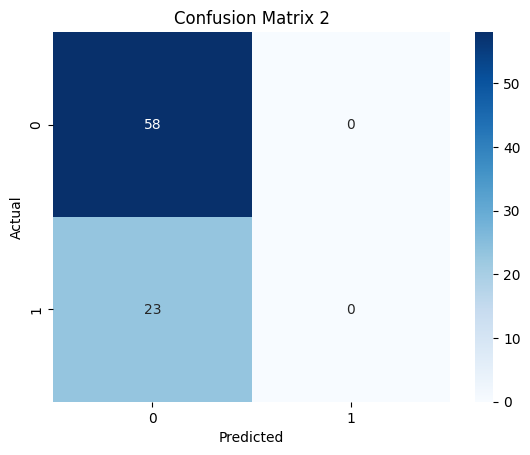

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, svm_pred_2)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')

# Show the plot
plt.show()

**Changing the parameters did not change anything!**



## Decision Tree

In [ ]:
# Training with a tree of max depth 3
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
start_time = time.time()
dt.fit(X_train, y_train)
tt_dt_1 = time.time() - start_time
times['dt_1'] = tt_dt_1

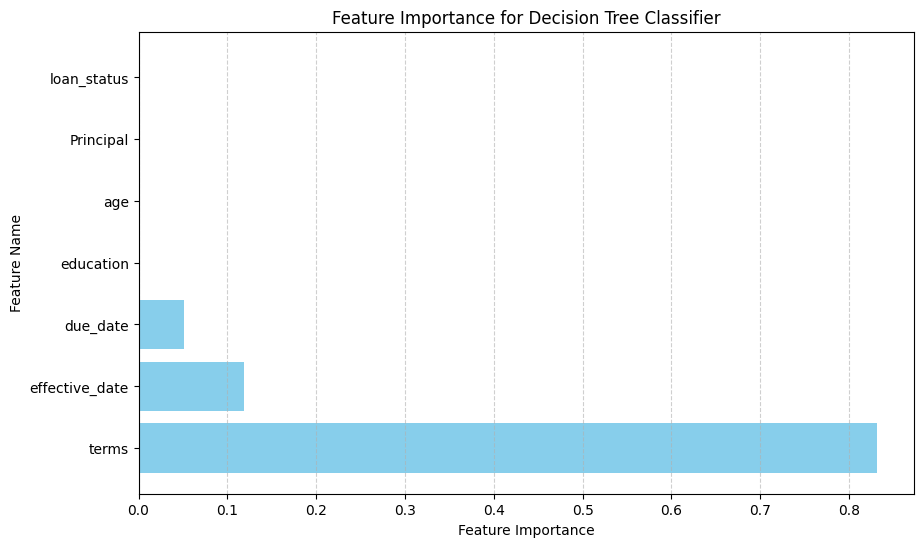

In [ ]:
# Get feature importances
feature_importances = dt.feature_importances_

# Get feature names
feature_names = feature_names = bank.columns.tolist()

# Sort feature importances and feature names by importance (optional for better readability)
feature_importances_sorted = feature_importances.argsort()  # Sort indices by importance
feature_names_sorted = [feature_names[i] for i in feature_importances_sorted]  # Sort names by importance (if applicable)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as desired
plt.barh(feature_names_sorted, feature_importances[feature_importances_sorted], color='skyblue')  # Use sorted importance and names (if applicable)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Decision Tree Classifier')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.show()

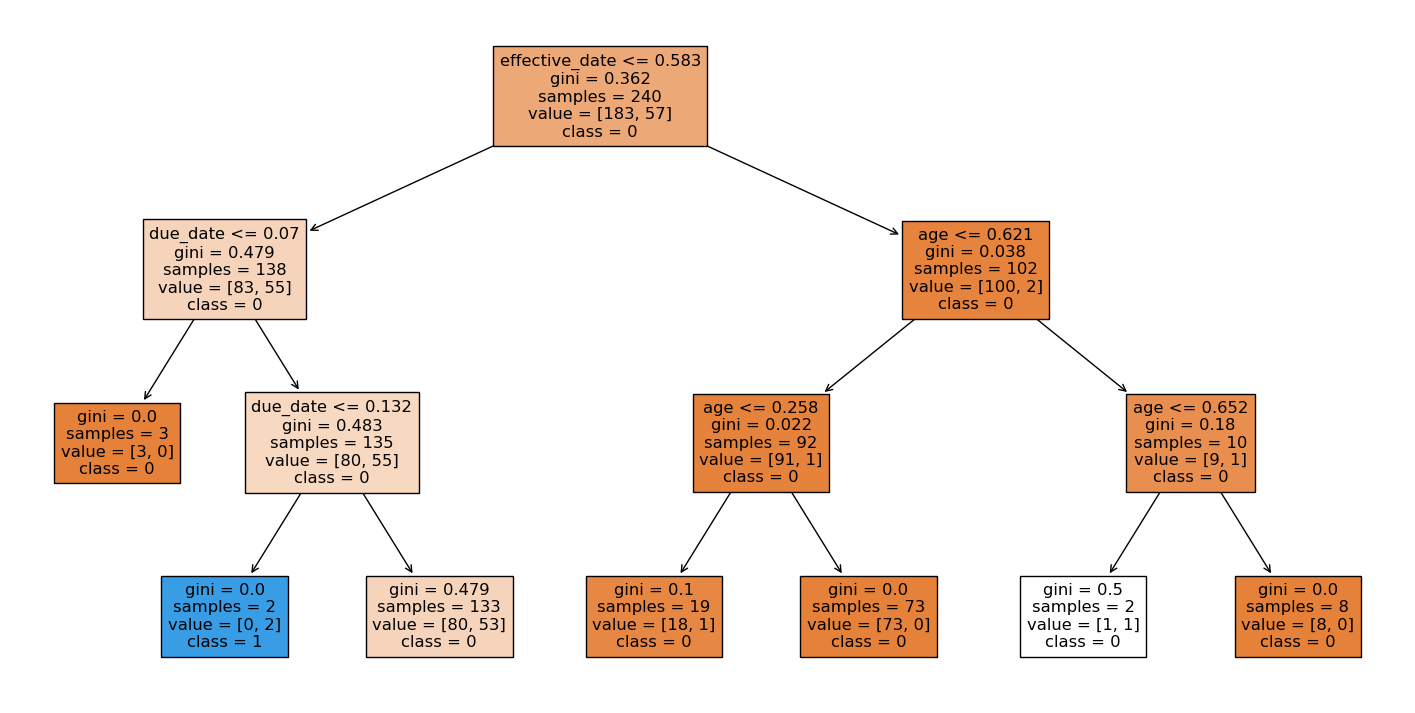

In [ ]:
# Convert feature names to strings
feature_names_str = [str(feature) for feature in X.columns]

# Convert class names to strings
class_names_str = [str(class_) for class_ in dt.classes_]

# Plot the decision tree with string names
plt.figure(figsize=(18, 9))
tree.plot_tree(dt, feature_names=feature_names_str, class_names=class_names_str, filled=True)
plt.show()

In [ ]:
dt_pred = dt.predict(X_test)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': dt_pred}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,0


In [ ]:
dt_acc = accuracy_score(y_test, dt_pred)
accuracies['dt_1'] = dt_acc
print("Accuracy:", dt_acc)

Accuracy: 0.7283950617283951


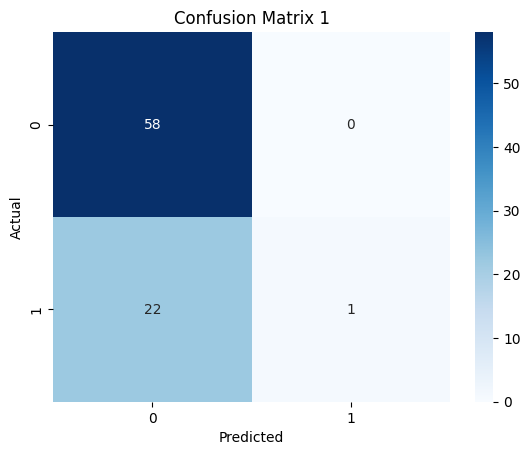

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, dt_pred)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')

# Show the plot
plt.show()

### Changing the Hyperparameters

In [ ]:
# Allowing the tree to go deep as it needs
dt_2 = DecisionTreeClassifier(max_depth=10, random_state=42)
start_time = time.time()
dt_2.fit(X_train, y_train)
tt_dt_2 = time.time() - start_time
times['dt_2'] = tt_dt_2

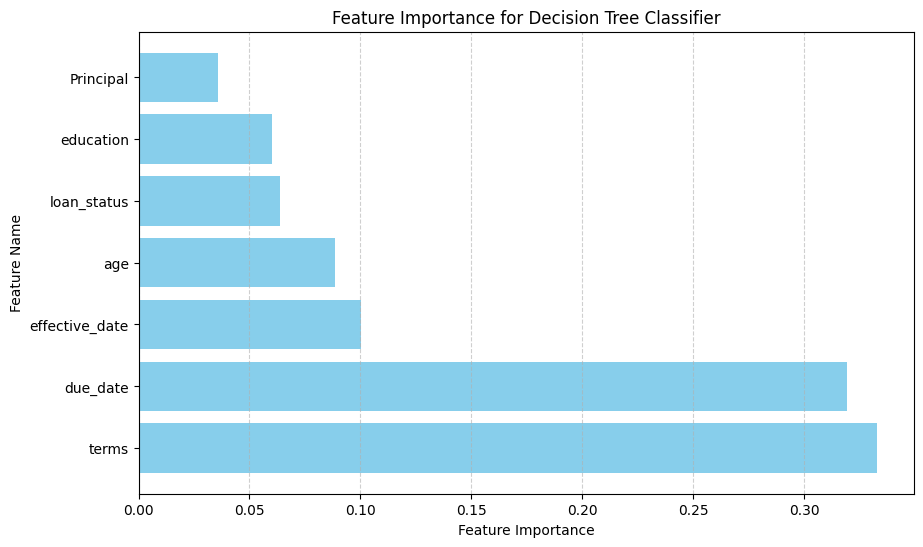

In [ ]:
# Get feature importances
feature_importances = dt_2.feature_importances_

# Get feature names
feature_names = feature_names = bank.columns.tolist()

# Sort feature importances and feature names by importance (optional for better readability)
feature_importances_sorted = feature_importances.argsort()  # Sort indices by importance
feature_names_sorted = [feature_names[i] for i in feature_importances_sorted]  # Sort names by importance (if applicable)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as desired
plt.barh(feature_names_sorted, feature_importances[feature_importances_sorted], color='skyblue')  # Use sorted importance and names (if applicable)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Decision Tree Classifier')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.show()

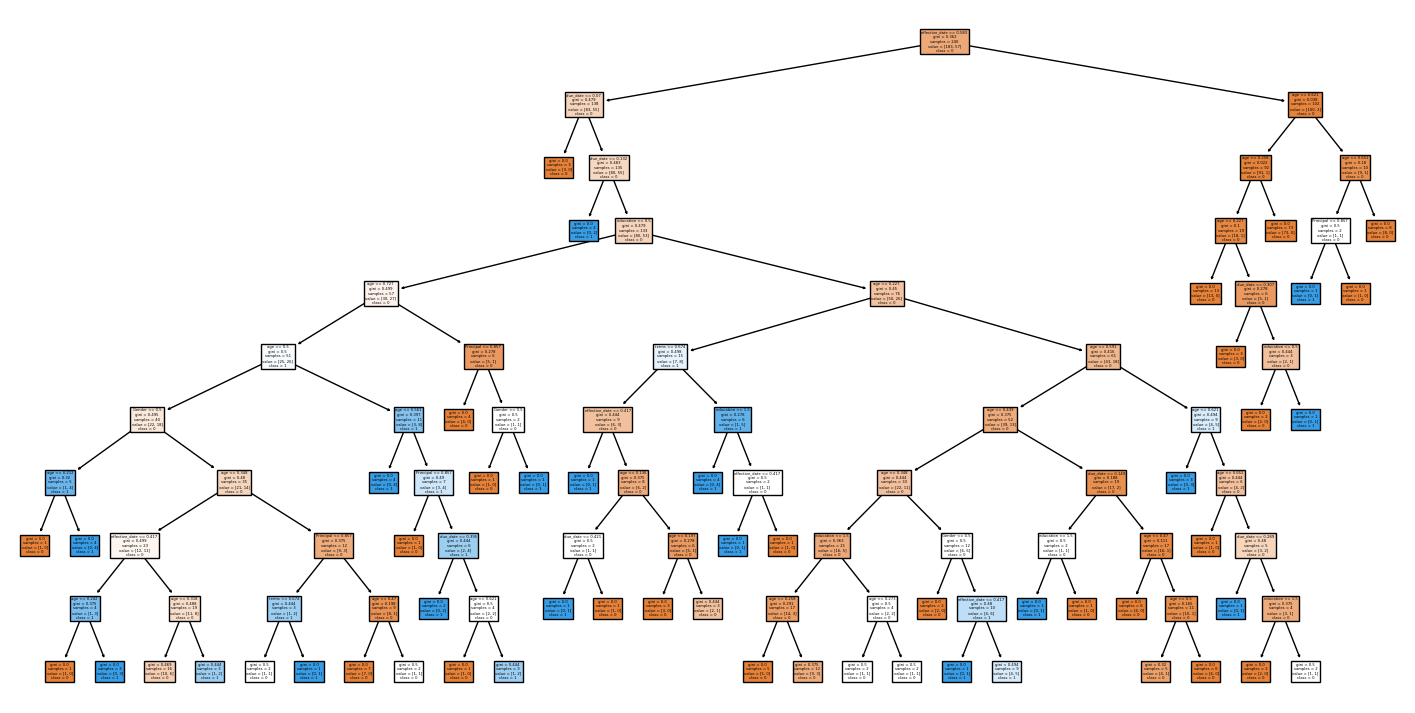

In [ ]:
# Convert feature names to strings
feature_names_str = [str(feature) for feature in X.columns]

# Convert class names to strings
class_names_str = [str(class_) for class_ in dt_2.classes_]

# Plot the decision tree with string names
plt.figure(figsize=(18, 9))
tree.plot_tree(dt_2, feature_names=feature_names_str, class_names=class_names_str, filled=True)
plt.show()

In [ ]:
dt_pred_2 = dt_2.predict(X_test)

In [ ]:
pd.DataFrame({'Test values':y_test, 'Predict': dt_pred_2}).head()

,Test values,Predict
188,0,0
142,0,0
212,0,0
13,0,0
111,0,0


In [ ]:
dt_acc_2 = accuracy_score(y_test, dt_pred_2)
accuracies['dt_2'] = dt_acc_2
print("Accuracy:", dt_acc_2)

Accuracy: 0.654320987654321


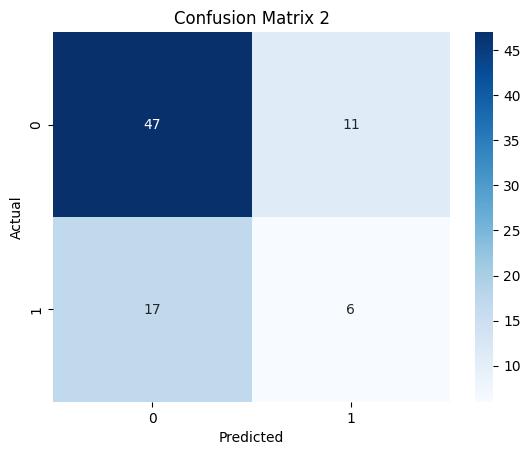

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, dt_pred_2)

# Create a confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels for axes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')

# Show the plot
plt.show()

**Simpler tree is better!**

# Comparison

## Training Time Comparison

In [ ]:
# Extract model names and times for plotting
models = list(times.keys())
times = list(times.values())

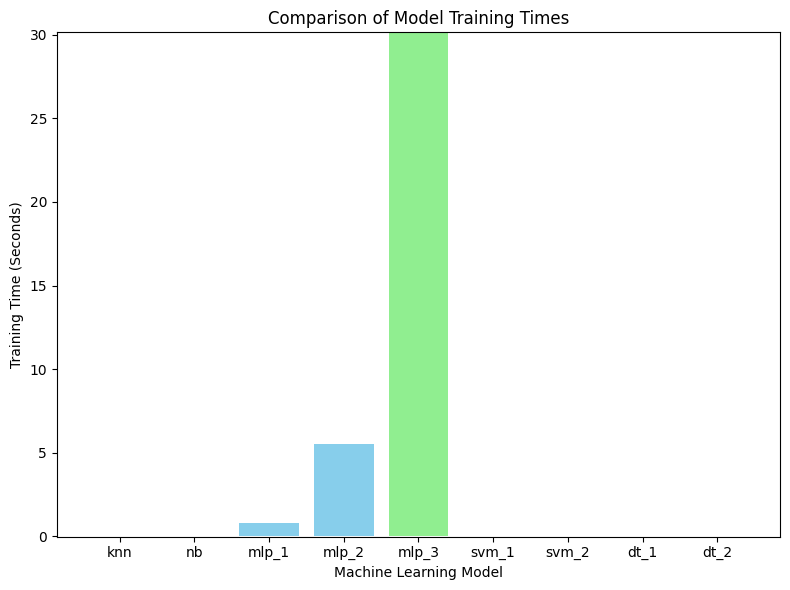

In [ ]:
# Get the minimum time
min_time = min(times)

# Get the maximum time
max_time = max(times)

# Define a color for the maximum time bar
max_time_color = 'lightgreen'

# Create a list to hold bar colors (default blue for all except max time)
bar_colors = ['skyblue'] * len(models)

# Find the index of the model with the maximum time
max_index = times.index(max_time)

# Set the color of the maximum time bar
bar_colors[max_index] = max_time_color

# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.bar(models, times, color=bar_colors)
plt.xlabel('Machine Learning Model')
plt.ylabel('Training Time (Seconds)')
plt.title('Comparison of Model Training Times')
plt.ylim(min_time - 0.01, max_time + 0.01)  # Set y-axis limits with a buffer below the minimum

# Display the plot
plt.tight_layout()
plt.show()

## **The MLP classifier with 1000 iterations had the maximum training time. The MLP classifier with 3 hidden layers follows it.**

## Accuracy Comparison

In [ ]:
# Extract model names and accuracies for plotting
models = list(accuracies.keys())
accuracies = list(accuracies.values())

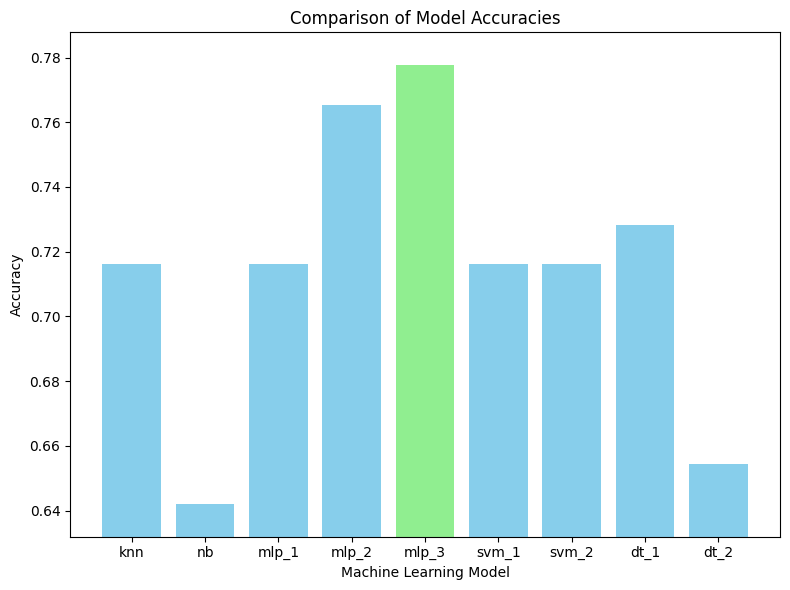

In [ ]:
# Get the minimum accuracy
min_accuracy = min(accuracies)

# Get the maximum accuracy
max_accuracy = max(accuracies)

# Define a color for the maximum accuracy bar
max_accuracy_color = 'lightgreen'

# Create a list to hold bar colors (default blue for all except max accuracy)
bar_colors = ['skyblue'] * len(models)

# Find the index of the model with the maximum accuracy
max_index = accuracies.index(max_accuracy)

# Set the color of the maximum accuracy bar
bar_colors[max_index] = max_accuracy_color

# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.bar(models, accuracies, color=bar_colors)
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(min_accuracy - 0.01, max_accuracy + 0.01)  # Set y-axis limits with a buffer below the minimum

# Display the plot
plt.tight_layout()
plt.show()

## **The MLP classifier is the best here with accuracy of 77.78%**
## The data gathered is not good; the model needed a lot of training, so increasing the number of iterations to 1000 made a big increase to the accuracy as well.

## **To achieve a small increase in accuracy from mlp_2 to mlp_3, a big increase in training time had to be done. Data Gathering is a crucial process!**